Davies-Bouldin Index: 1.1725
Silhouette Score: 0.2666

Cluster Summary:
          Avg Region  Avg Signup Date  Avg Quantity  Avg Unique Products
Cluster                                                                
0          0.620690     1.692004e+09     21.379310             7.827586
1          0.796610     1.687698e+09      6.966102             2.864407
2          2.175439     1.716941e+09     12.789474             5.035088
3          2.407407     1.661944e+09     14.388889             5.388889


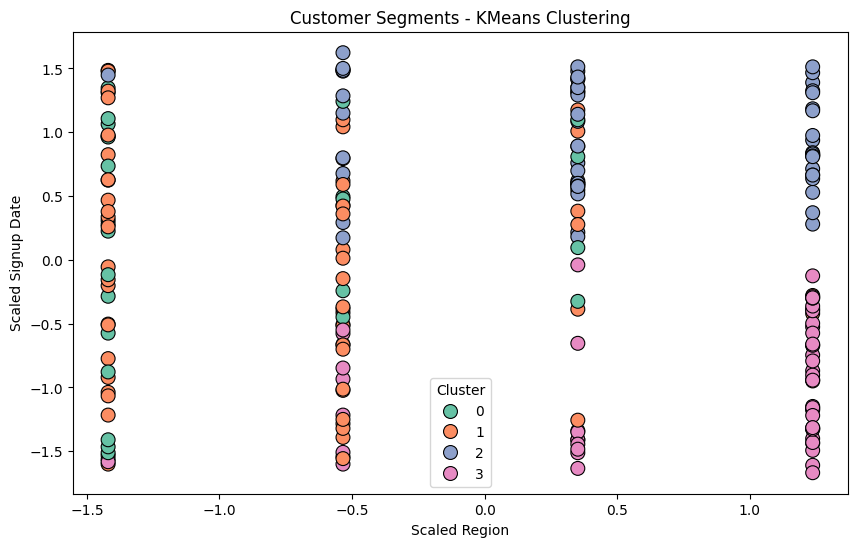

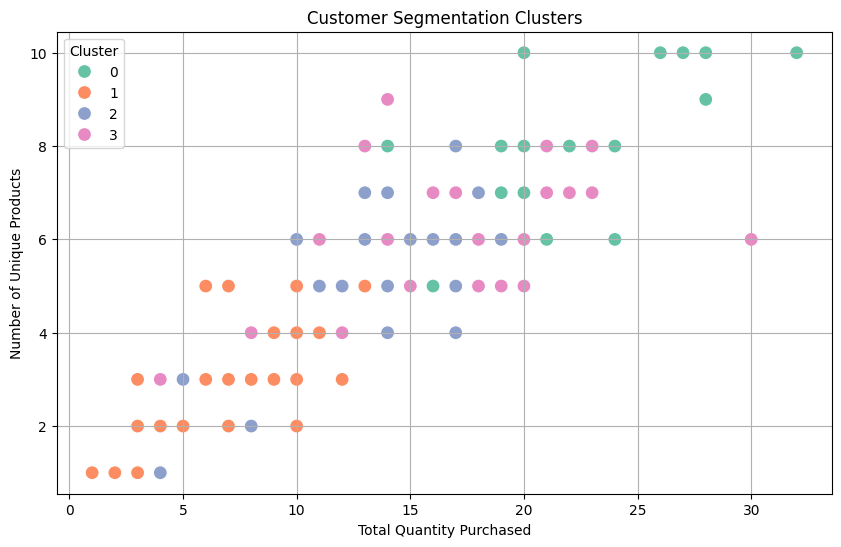

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
customers = pd.read_csv("/content/drive/MyDrive/Datasets/Customers.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Datasets/Transactions.csv")

# Preprocessing for customers
le = LabelEncoder()
customers['Region'] = le.fit_transform(customers['Region'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate']).apply(lambda x: x.timestamp())

# Merge customer and transaction data
merged_data = transactions.merge(customers, on='CustomerID')

# Aggregate transaction data
customer_transaction_data = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'ProductID': 'nunique'
}).reset_index()

# Combine the profile and transaction data for clustering
features = pd.merge(customers[['CustomerID', 'Region', 'SignupDate']], customer_transaction_data, on='CustomerID')

# Select features for clustering
clustering_features = features[['Region', 'SignupDate', 'Quantity', 'ProductID']]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Apply KMeans clustering
optimal_clusters = 4  # Chosen manually or based on the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels
features['Cluster'] = clusters

# Cluster evaluation metrics
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Cluster summary
cluster_summary = features.groupby('Cluster').agg({
    'Region': 'mean',
    'SignupDate': 'mean',
    'Quantity': 'mean',
    'ProductID': 'mean'
}).rename(columns={
    'Region': 'Avg Region',
    'SignupDate': 'Avg Signup Date',
    'Quantity': 'Avg Quantity',
    'ProductID': 'Avg Unique Products'
})
print("\nCluster Summary:\n", cluster_summary)

# Custom color palette for clusters
cluster_palette = sns.color_palette("Set2", optimal_clusters)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=scaled_features[:, 0], y=scaled_features[:, 1],
    hue=features['Cluster'], palette=cluster_palette, s=100, edgecolor='black'
)
plt.title("Customer Segments - KMeans Clustering")
plt.xlabel("Scaled Region")
plt.ylabel("Scaled Signup Date")
plt.legend(title="Cluster")
plt.show()

# Additional visualization: Total Quantity vs. Unique Products
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='Quantity', y='ProductID', hue='Cluster', palette=cluster_palette, s=100)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Number of Unique Products')
plt.legend(title='Cluster')
plt.grid()
plt.show()
